# Exemplo da aplicação de Deconvolução de Euler 2D e Amplitude do Sinal Analítico (ASA) 2D para estimar a posição de estruturas no embasamento.

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
%matplotlib inline
import numpy as np
from scipy import interpolate

from fatiando import gravmag, mesher, utils, gridder
from fatiando.gravmag import prism, fourier
from fatiando.mesher import Prism, Polygon
from fatiando.utils import ang2vec, si2nt
from fatiando.gridder import regular
from fatiando.vis import mpl

Na Deconvolução de Euler 2D, as coordenadas $\color{blue}{y_{0}}$ e $\color{blue}{z_{0}}$ da fonte, bem como o nível de base $\color{green}{B}$ são estimados via solução de um sistema linear. Cada linha deste sistema linear e dada por:

$\color{blue}{y_{0}}\dfrac{\partial \Delta T_{i}}{\partial y} + 
 \color{blue}{z_{0}}\dfrac{\partial \Delta T_{i}}{\partial z} +
 \eta \, \color{green}{B} = 
 y_{i}\dfrac{\partial \Delta T_{i}}{\partial y} + 
 z_{i}\dfrac{\partial \Delta T_{i}}{\partial z} +
 \eta \, \Delta T_{i}$ ,

em que $y_{i}$ e $z_{i}$ são as coordenadas do $i$-ésimo ponto de observação, $\Delta T_{i}$, $\dfrac{\partial \Delta T_{i}}{\partial y}$ e $\dfrac{\partial \Delta T_{i}}{\partial z}$ são, respectivamente, a anomalia de campo total (ACT) e suas derivadas espaciais no $i$-ésimo ponto de observação e $\eta$ é um escalar positivo denominado **índice estrutural**. Este parâmetro define o formato da fonte cuja posição será estimada via Deconvolução de Euler. Uma superfície ondulada, tal como o relevo do embasamento sob uma bacia sedimentar, **NÃO** é uma fonte cuja posição pode ser estimada via Deconvolução de Euler. Contudo, em geral, uma falha (com rejeito ou sem) pode ser determinada via Deconvolução de Euler. 

A Amplitude do Sinal Analítico (ASA) é uma grandeza que independe da direção de magnetização se esta é bidimensional (2D), como é o caso do exemplo numérico mostrado aqui. A ASA calculada no $i$-ésimo ponto de observação é dada por:

$ASA_{i} = \sqrt{\left( \dfrac{\partial \Delta T_{i}}{\partial y} \right)^{2} + 
                 \left( \dfrac{\partial \Delta T_{i}}{\partial z} \right)^{2}}$ .

In [2]:
def Euler2D(tf, Dytf, Dztf, y, z, si, npontos):
    '''
    Deconvolução de Euler 2D
    
    sistema de coordenadas
      x: dimensão infinita
      y: direção ao longo do perfil
      z: aponta para baixo
    
    input
      tf: array com a anomalia de campo total (ACT)
      Dytf: array com a derivada espacial da ACT na direção y
      Dztf: array com a derivada espacial da ACT na direção z
      y: array com a coordenadas das observações ao longo do perfil
      si: índice estrutural
      npontos: número de pontos em cada janela
      
    output
      y0: array com as coordenadas y estimadas para cada janela
          de dados
      z0: array com as coordenadas z estimadas para cada janela
          de dados
      b: array com os níveis de base estimados para cada janela
          de dados

    '''

    y0 = np.zeros(len(y) + 1 - npontos)
    z0 = np.zeros(len(y) + 1 - npontos)
    b = np.zeros(len(y) + 1 - npontos)
    
    vsi = si*np.ones(npontos)

    # Janela móvel
    for i in range(len(y) + 1 - npontos):
        S = np.vstack((Dytf[i:i+npontos],Dztf[i:i+npontos],vsi)).T
        s = Dytf[i:i+npontos]*y[i:i+npontos] + \
            Dztf[i:i+npontos]*z[i:i+npontos] + \
            vsi*tf[i:i+npontos]
        STS = S.T.dot(S)
        STs = S.T.dot(s)
        # Coordenadas estimadas
        p = np.linalg.solve(STS,STs)
        y0[i] = p[0]
        z0[i] = p[1]
        b[i]  = p[2]

    return y0, z0, b

In [3]:
def ASA2D(Dytf, Dztf):
    '''
    Amplitude do Sinal Analítico 2D
    
    sistema de coordenadas
      x: dimensão infinita
      y: direção ao longo do perfil
      z: aponta para baixo
    
    input
      Dytf: array com a derivada espacial da ACT na direção y
      Dztf: array com a derivada espacial da ACT na direção z
      
    output
      asa2D: array com a amplitude do sinal analítico 2D

    '''

    asa2D = np.sqrt(Dytf**2 + Dztf**2)

    return asa2D

## Coordenadas das observações e do modelo

In [4]:
ymin = 0.0
ymax = 100000.0
ny = 201
dy = (ymax - ymin)/(ny - 1)
L = ymax - ymin
y = np.linspace(ymin, ymax, ny)
x = np.zeros_like(y)
z = np.zeros_like(y)-150.0

zmin = -2000.0
zmax = 8000.0
xmin = -100000.0
xmax =  100000.0

area = [ymin, ymax, zmax, zmin]

incs, decs = 18.0, 10.0 # inclinação e declinação dos diques e soleiras
inc, dec = -39.8, -22.5 # inclinação e declinação do campo geomagnético
intens = 3.0 # intensidade da magnetização dos diques e soleiras

## Bacia

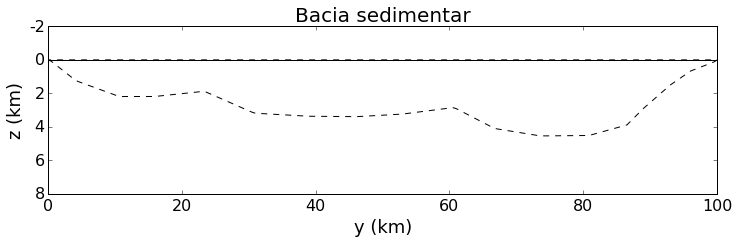

In [5]:
poligono_bacia = []
bacia = []

# Embasamento inicial
#mpl.close('all')
#axes = mpl.pyplot.figure().add_subplot(1,1,1)
#mpl.ylim(zmax, zmin)
#mpl.xlim(ymin, ymax)
#mpl.xlabel('y (m)')
#mpl.ylabel('z (m)')
#mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
#d = mpl.draw_polygon(area, axes, color='r')

# Embasamento interpolado
#f = interpolate.interp1d(d[:,0], d[:,1], kind = 'linear', bounds_error = False, fill_value = 0.0)
nb = 201
#by = np.linspace(ymin, ymax, nb)
#bz = f(by)
#bz[0] = 0.0
#bz[nb-1] = 0.0

by = [0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.,  3500.,
      4000.,  4500.,  5000.,  5500.,  6000.,  6500.,  7000.,  7500.,
      8000.,  8500.,  9000.,  9500., 10000., 10500., 11000., 11500.,
     12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
     16000., 16500., 17000., 17500., 18000., 18500., 19000., 19500.,
     20000., 20500., 21000., 21500., 22000., 22500., 23000., 23500.,
     24000., 24500., 25000., 25500., 26000., 26500., 27000., 27500.,
     28000., 28500., 29000., 29500., 30000., 30500., 31000., 31500.,
     32000., 32500., 33000., 33500., 34000., 34500., 35000., 35500.,
     36000., 36500., 37000., 37500., 38000., 38500., 39000., 39500.,
     40000., 40500., 41000., 41500., 42000., 42500., 43000., 43500.,
     44000., 44500., 45000., 45500., 46000., 46500., 47000., 47500.,
     48000., 48500., 49000., 49500., 50000., 50500., 51000., 51500.,
     52000., 52500., 53000., 53500., 54000., 54500., 55000., 55500.,
     56000., 56500., 57000., 57500., 58000., 58500., 59000., 59500.,
     60000., 60500., 61000., 61500., 62000., 62500., 63000., 63500.,
     64000., 64500., 65000., 65500., 66000., 66500., 67000., 67500.,
     68000., 68500., 69000., 69500., 70000., 70500., 71000., 71500.,
     72000., 72500., 73000., 73500., 74000., 74500., 75000., 75500.,
     76000., 76500., 77000., 77500., 78000., 78500., 79000., 79500.,
     80000., 80500., 81000., 81500., 82000., 82500., 83000., 83500.,
     84000., 84500., 85000., 85500., 86000., 86500., 87000., 87500.,
     88000., 88500., 89000., 89500., 90000., 90500., 91000., 91500.,
     92000., 92500., 93000., 93500., 94000., 94500., 95000., 95500.,
     96000., 96500., 97000., 97500., 98000., 98500., 99000., 99500.,
    100000.]

bz = [0., 75.36886148, 232.38273508, 389.39660868, 546.41048227,
     703.42435587, 860.43822946, 1017.45210306, 1174.46597666, 1286.7416318,
    1359.70188285, 1432.66213389, 1505.62238494, 1578.58263598, 1651.54288703,
    1724.50313808, 1797.46338912, 1870.42364017, 1943.38389121, 2016.34414226,
    2089.30439331, 2162.26464435, 2189.33054393, 2189.33054393, 2189.33054393,
    2189.33054393, 2189.33054393, 2189.33054393, 2189.33054393, 2189.33054393,
    2189.33054393, 2189.33054393, 2186.27728147, 2165.24369558, 2144.21010969,
    2123.1765238, 2102.14293792, 2081.10935203, 2060.07576614, 2039.04218026,
    2018.00859437, 1996.97500848, 1975.94142259, 1954.90783671, 1933.87425082,
    1912.84066493, 1891.80707905, 1895.31267669, 1982.95261789, 2070.59255909,
    2158.23250028, 2245.87244148, 2333.51238268, 2421.15232387, 2508.79226507,
    2596.43220626, 2684.07214746, 2771.71208866, 2859.35202985, 2946.99197105,
    3034.63191225, 3122.27185344, 3186.62160712, 3198.26198906, 3209.90237099,
    3221.54275292, 3233.18313486, 3244.82351679, 3256.46389872, 3268.10428066,
    3279.74466259, 3291.38504452, 3303.02542646, 3314.66580839, 3326.30619032,
    3337.94657226, 3349.58695419, 3361.22733612, 3367.12654077, 3368.87933959,
    3370.63213841, 3372.38493724, 3374.13773606, 3375.89053489, 3377.64333371,
    3379.39613253, 3381.14893136, 3382.90173018, 3384.65452901, 3386.40732783,
    3388.16012665, 3389.91292548, 3391.6657243, 3384.69111494, 3373.24636968,
    3361.80162442, 3350.35687915, 3338.91213389, 3327.46738863, 3316.02264337,
    3304.5778981, 3293.13315284, 3281.68840758, 3270.24366232, 3258.79891706,
    3247.35417179, 3235.90942653, 3210.99427439, 3185.3941863, 3159.79409822,
    3134.19401013, 3108.59392204, 3082.99383396, 3057.39374587, 3031.79365778,
    3006.1935697, 2980.59348161, 2954.99339353, 2929.39330544, 2903.79321735,
    2878.19312927, 2852.59304118, 2908.36820084, 3012.13389121, 3115.89958159,
    3219.66527197, 3323.43096234, 3427.19665272, 3530.9623431, 3634.72803347,
    3738.49372385, 3842.25941423, 3946.0251046, 4049.79079498, 4115.58577406,
    4148.0125523, 4180.43933054, 4212.86610879, 4245.29288703, 4277.71966527,
    4310.14644351, 4342.57322176, 4375., 4407.42677824, 4439.85355649,
    4472.28033473, 4504.70711297, 4537.13389121, 4541.40516039, 4539.60367271,
    4537.80218503, 4536.00069735, 4534.19920967, 4532.39772199, 4530.59623431,
    4528.79474663, 4526.99325895, 4525.19177127, 4523.39028359, 4521.58879591,
    4519.78730823, 4517.98582055, 4499.70113568, 4444.11237298, 4388.52361028,
    4332.93484758, 4277.34608488, 4221.75732218, 4166.16855947, 4110.57979677,
    4054.99103407, 3999.40227137, 3943.81350867, 3885.89609484, 3685.93096234,
    3485.96582985, 3286.00069735, 3086.03556485, 2890.48117155, 2715.37656904,
    2540.27196653, 2365.16736402, 2190.06276151, 2014.958159, 1839.85355649,
    1664.74895397, 1493.79358438, 1355.43933054, 1217.08507671, 1078.73082287,
     940.37656904, 802.0223152, 667.57322176, 589.74895397, 511.92468619,
     434.10041841, 356.27615063, 278.45188285, 200.62761506, 122.80334728,
       0.]

poligono_bacia = mesher.Polygon(np.vstack((by, bz)).T)

# Visualização 2D da bacia
mpl.figure(figsize=(12,3))
mpl.title('Bacia sedimentar', fontsize=20)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
mpl.polygon(poligono_bacia, style='--k', linewidth=1)
mpl.ylim(zmax, zmin)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()
mpl.show()

# Lista de prismas que formam a bacia
db = (ymax - ymin)/(nb - 1)
for i in range(nb):
    bacia.append(mesher.Prism(xmin, xmax, 
                              by[i], by[i] + db,
                              0.0, bz[i], {'magnetization': utils.ang2vec(-0.1, inc, dec)}))

## Diques + Soleiras

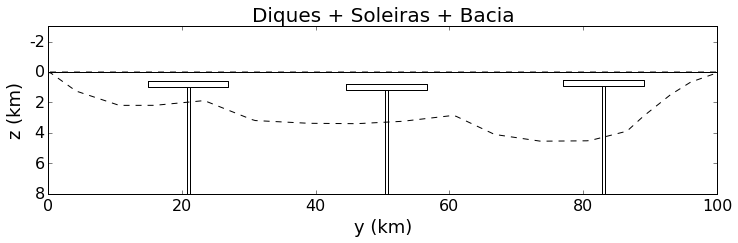

In [6]:
# Topo dos diques
d = np.array([[83000.0, 700.0],
              [50600.0, 1000.0],
              [21000.0, 800.0]])

Ldique = 200.0
Lsoleirasy = 6000.0
Lsoleirasz = 200.0

diques = []
poligonos_diques = []

soleiras = []
poligonos_soleiras = []

for i, p in enumerate(d):
    # Soleiras
    soleiras.append(mesher.Prism(xmin, xmax, 
                               p[0] - Lsoleirasy, p[0] + Lsoleirasy,
                               p[1] - Lsoleirasz, p[1] + Lsoleirasz, 
                               {'magnetization': utils.ang2vec(intens, incs, decs)}))
    poligonos_soleiras.append(mesher.Polygon([[p[0] - Lsoleirasy, p[1] - Lsoleirasz],
                                              [p[0] + Lsoleirasy, p[1] - Lsoleirasz],
                                              [p[0] + Lsoleirasy, p[1] + Lsoleirasz],
                                              [p[0] - Lsoleirasy, p[1] + Lsoleirasz]]))
    # Diques
    diques.append(mesher.Prism(xmin, xmax, 
                              p[0] - Ldique, p[0] + Ldique,
                              p[1] + Lsoleirasz, 10000, {'magnetization': utils.ang2vec(intens, incs, decs)}))
    poligonos_diques.append(mesher.Polygon([[p[0] - Ldique, p[1] + Lsoleirasz], 
                                            [p[0] + Ldique, p[1] + Lsoleirasz], 
                                            [p[0] + Ldique, 100000],
                                            [p[0] - Ldique, 100000]]))
    

# Visualização dos diques e soleiras + bacia
lambida = 0.10
mpl.figure(figsize=(12,3))
mpl.title('Diques + Soleiras + Bacia', fontsize=20)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
mpl.polygon(poligono_bacia, style='--k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
for i, p in enumerate(poligonos_soleiras):
    mpl.polygon(p, style='-k', linewidth=1)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()
mpl.show()

## Anomalia de campo total (ACT)

In [7]:
B = 30.0 # nível de base

tf = gravmag.prism.tf(x, y, z, diques, inc, dec) + \
     gravmag.prism.tf(x, y, z, soleiras, inc, dec) + \
     gravmag.prism.tf(x, y, z, bacia, inc, dec) + B

## Visualização da anomalia de campo total

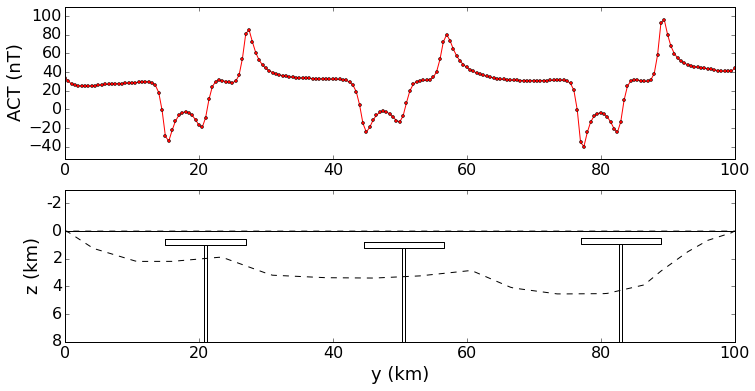

In [8]:
mpl.close('all')
mpl.figure(figsize=(12,6))

lambida = 0.10

mpl.subplot(2,1,1)
mpl.plot(0.001*y, tf, 'r-')
mpl.plot(0.001*y, tf, 'ro', markersize=3)
vmax = np.max(tf)
vmin = np.min(tf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('ACT (nT)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.subplot(2,1,2)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
mpl.polygon(poligono_bacia, style='--k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
for i, p in enumerate(poligonos_soleiras):
    mpl.polygon(p, style='-k', linewidth=1)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()

mpl.show()

## Derivadas espaciais da ACT

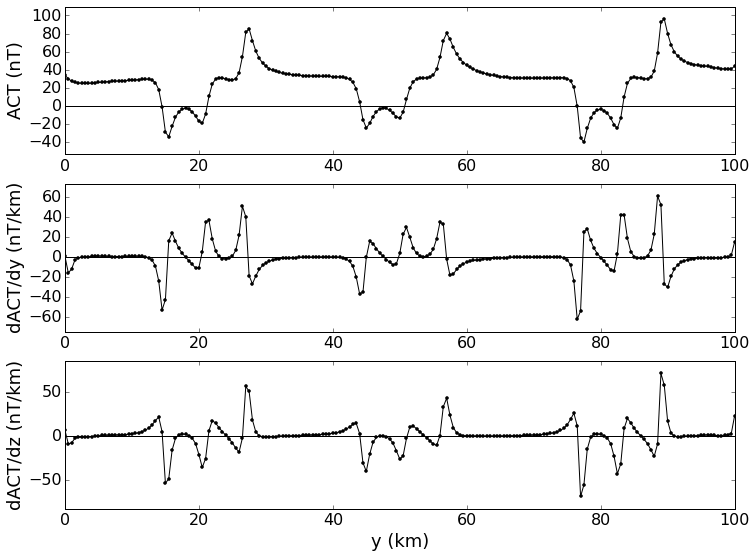

In [9]:
delta = 10.0

# Derivadas numéricas
Dytf  = gravmag.prism.tf(x, y + delta, z, bacia, inc, dec)
Dytf -= gravmag.prism.tf(x, y - delta, z, bacia, inc, dec)
Dytf += gravmag.prism.tf(x, y + delta, z, diques, inc, dec)
Dytf -= gravmag.prism.tf(x, y - delta, z, diques, inc, dec)
Dytf += gravmag.prism.tf(x, y + delta, z, soleiras, inc, dec)
Dytf -= gravmag.prism.tf(x, y - delta, z, soleiras, inc, dec)
Dytf  = Dytf/(2.0*delta) # nT/km

Dztf  = gravmag.prism.tf(x, y, z + delta, bacia, inc, dec)
Dztf -= gravmag.prism.tf(x, y, z - delta, bacia, inc, dec)
Dztf += gravmag.prism.tf(x, y, z + delta, diques, inc, dec)
Dztf -= gravmag.prism.tf(x, y, z - delta, diques, inc, dec)
Dztf += gravmag.prism.tf(x, y, z + delta, soleiras, inc, dec)
Dztf -= gravmag.prism.tf(x, y, z - delta, soleiras, inc, dec)
Dztf  = Dztf/(2.0*delta) # nT/km

# Visualização da anomalia de campo total + derivadas em y e z
mpl.close('all')
mpl.figure(figsize=(12,9))

lambida = 0.10

mpl.subplot(3,1,1)
mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
mpl.plot(0.001*y, tf, 'k-')
mpl.plot(0.001*y, tf, 'ko', markersize=3)
vmax = np.max(tf)
vmin = np.min(tf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('ACT (nT)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.subplot(3,1,2)
mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
mpl.plot(0.001*y, 1000.0*Dytf, 'k-')
mpl.plot(0.001*y, 1000.0*Dytf, 'ko', markersize=3)
vmax = np.max(1000.0*Dytf)
vmin = np.min(1000.0*Dytf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('dACT/dy (nT/km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.subplot(3,1,3)
mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
mpl.plot(0.001*y, 1000.0*Dztf, 'k-')
mpl.plot(0.001*y, 1000.0*Dztf, 'ko', markersize=3)
vmax = np.max(1000.0*Dztf)
vmin = np.min(1000.0*Dztf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin,0.001* ymax)
mpl.ylabel('dACT/dz (nT/km)', fontsize=18)
mpl.xlabel('y (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.show()

## Amplitude do Sinal Analítico (ASA) 2D

In [10]:
asa2D = ASA2D(Dytf, Dztf)

## Visualização da ASA

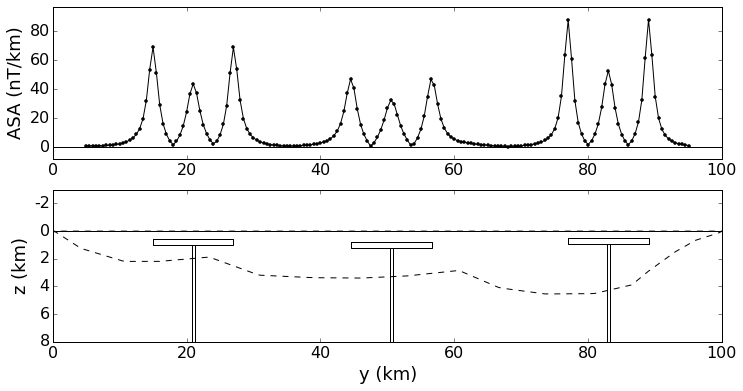

In [11]:
lambida = 0.10

mpl.close('all')
mpl.figure(figsize=(12,6))

#mpl.subplot(3,1,1)
#mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
#mpl.plot(0.001*y, tf, 'k-')
#mpl.plot(0.001*y, tf, 'ko', markersize=3)
#vmax = np.max(tf)
#vmin = np.min(tf)
#dv = lambida*(vmax - vmin)
#mpl.ylim(vmin - dv, vmax + dv)
#mpl.xlim(0.001*ymin, 0.001*ymax)
#mpl.ylabel('ACT (nT)')

#mpl.subplot(3,1,2)
mpl.subplot(2,1,1)
mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
mpl.plot(0.001*y[10:ny-10], 1000.0*asa2D[10:ny-10], 'k-')
mpl.plot(0.001*y[10:ny-10], 1000.0*asa2D[10:ny-10], 'ko', markersize=3)
vmax = np.max(1000.0*asa2D[10:ny-10])
vmin = np.min(1000.0*asa2D[10:ny-10])
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('ASA (nT/km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

#mpl.subplot(3,1,3)
mpl.subplot(2,1,2)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
mpl.polygon(poligono_bacia, style='--k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
for i, p in enumerate(poligonos_soleiras):
    mpl.polygon(p, style='-k', linewidth=1)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()

mpl.show()

## Parâmetros da Deconvolução de Euler

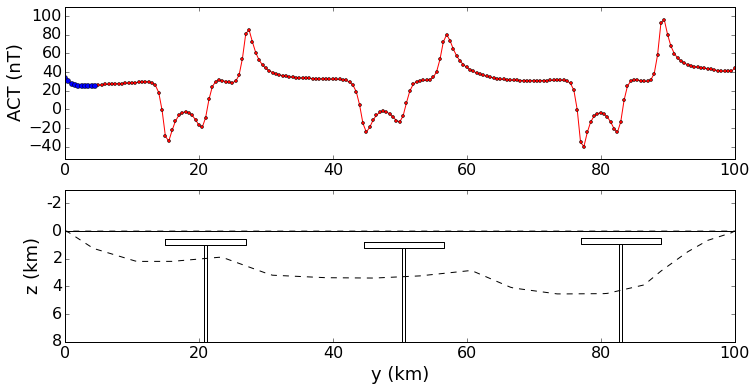

In [12]:
npontos = 10 # número de pontos por janela
#npontos = ny # apenas uma janela

dymedio = 0.5*(y[npontos-1] - y[0])

ymedio = np.linspace(ymin + dymedio, 
                     ymax - dymedio, 
                     len(y) + 1 - npontos)

n = [0.5,1,1.5,2,3] # lista de índices estruturais
colors = ['ro','go','bo','yo','ko']
labels = ['0.5','1','1.5','2','3']

mpl.close('all')
mpl.figure(figsize=(12,6))

lambida = 0.10

mpl.subplot(2,1,1)
mpl.plot(0.001*y, tf, 'r-')
mpl.plot(0.001*y, tf, 'ro', markersize=3)
mpl.plot(0.001*y[:npontos], tf[:npontos], 'b-', markersize=5)
mpl.plot(0.001*y[:npontos], tf[:npontos], 'bo', markersize=5)
vmax = np.max(tf)
vmin = np.min(tf)
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('ACT (nT)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

mpl.subplot(2,1,2)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
mpl.polygon(poligono_bacia, style='--k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
for i, p in enumerate(poligonos_soleiras):
    mpl.polygon(p, style='-k', linewidth=1)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()

mpl.show()

## Deconvolução de Euler

In [13]:
estimativas_y0 = []
estimativas_z0 = []
estimativas_b  = []

for j in range(len(n)):
    
    y0, z0, b = Euler2D(tf, Dytf, Dztf, y, z, n[j], npontos)
    estimativas_y0.append(y0)
    estimativas_z0.append(z0)
    estimativas_b.append(b)

## Visualização das estimativas + ACT

In [14]:
lambida = 0.10 # parâmetros que controla os eixos

### Todas juntas

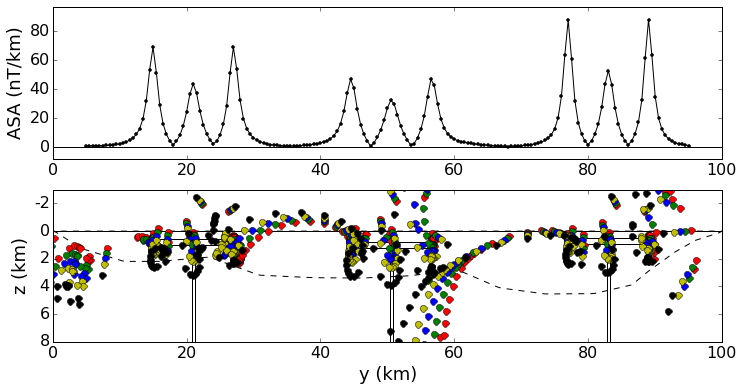

In [15]:
mpl.close('all')
mpl.figure(figsize=(12,6))

#mpl.subplot(3,1,1)
#mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
#mpl.plot(0.001*y, tf, 'r-')
#mpl.plot(0.001*y, tf, 'ro', markersize=3)
#mpl.plot(0.001*y[:npontos], tf[:npontos], 'b-')
#mpl.plot(0.001*y[:npontos], tf[:npontos], 'bo', markersize=5)
#vmax = np.max(tf)
#vmin = np.min(tf)
#dv = lambida*(vmax - vmin)
#mpl.ylim(vmin - dv, vmax + dv)
#mpl.xlim(0.001*ymin, 0.001*ymax)
#mpl.ylabel('ACT (nT)')

#mpl.subplot(3,1,2)
mpl.subplot(2,1,1)
mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
mpl.plot(0.001*y[10:ny-10], 1000.0*asa2D[10:ny-10], 'k-')
mpl.plot(0.001*y[10:ny-10], 1000.0*asa2D[10:ny-10], 'ko', markersize=3)
vmax = np.max(1000.0*asa2D[10:ny-10])
vmin = np.min(1000.0*asa2D[10:ny-10])
dv = lambida*(vmax - vmin)
mpl.ylim(vmin - dv, vmax + dv)
mpl.xlim(0.001*ymin, 0.001*ymax)
mpl.ylabel('ASA (nT/km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)

#mpl.subplot(3,1,3)
mpl.subplot(2,1,2)
mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
mpl.polygon(poligono_bacia, style='--k', linewidth=1)
for i, p in enumerate(poligonos_diques):
    mpl.polygon(p, style='-k', linewidth=1)
for i, p in enumerate(poligonos_soleiras):
    mpl.polygon(p, style='-k', linewidth=1)
for j in range(len(n)):
    mpl.plot(estimativas_y0[j], estimativas_z0[j], colors[j], label=labels[j], markersize=7)
dv = lambida*(zmax - zmin)
mpl.ylim(zmax, zmin - dv)
mpl.xlim(ymin, ymax)
mpl.xlabel('y (km)', fontsize=18)
mpl.ylabel('z (km)', fontsize=18)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.m2km()

mpl.show()

### Separadas

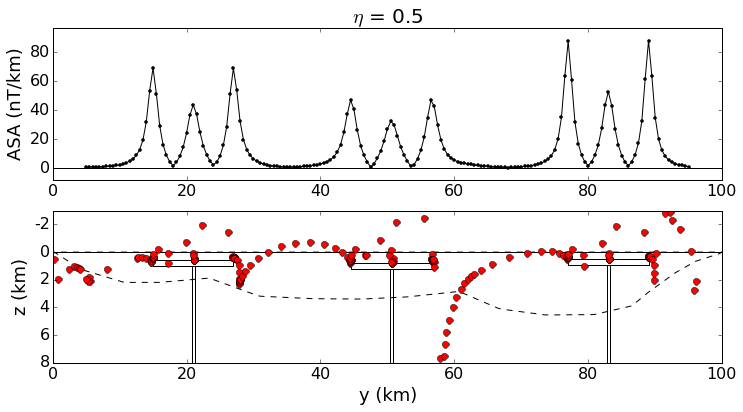

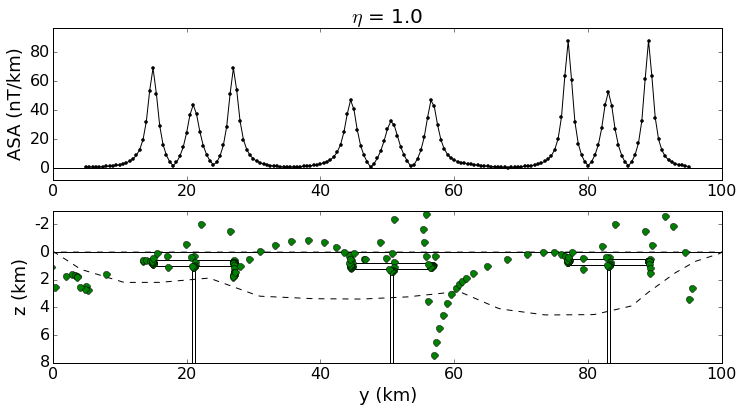

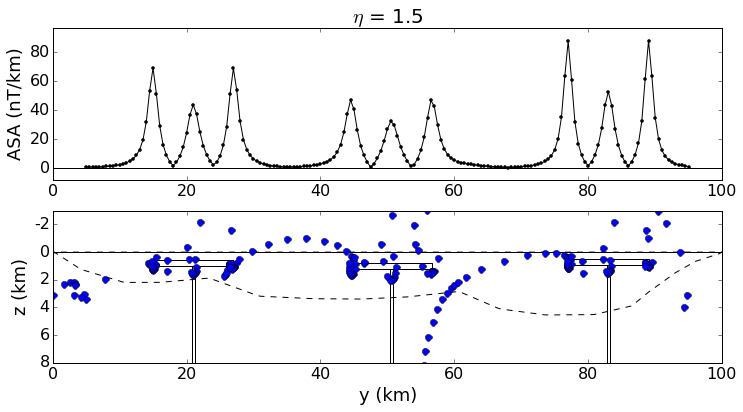

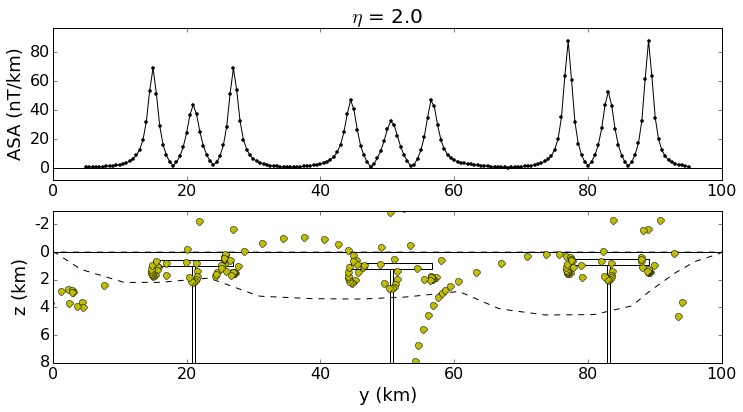

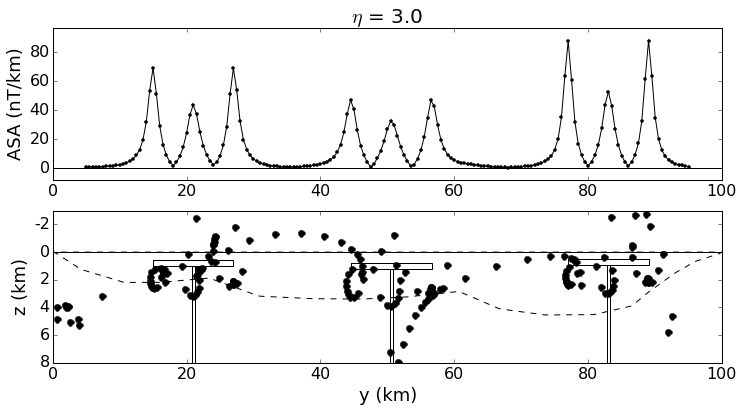

In [16]:
for j in range(len(n)):
    mpl.close('all')
    mpl.figure(figsize=(12,6))

    #mpl.subplot(3,1,1)
    #mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
    #mpl.plot(0.001*y, tf, 'r-')
    #mpl.plot(0.001*y, tf, 'ro', markersize=3)
    #mpl.plot(0.001*y[:npontos], tf[:npontos], 'b-')
    #mpl.plot(0.001*y[:npontos], tf[:npontos], 'bo', markersize=5)
    #vmax = np.max(tf)
    #vmin = np.min(tf)
    #dv = lambida*(vmax - vmin)
    #mpl.ylim(vmin - dv, vmax + dv)
    #mpl.xlim(0.001*ymin, 0.001*ymax)
    #mpl.ylabel('ACT (nT)')

    #mpl.subplot(3,1,2)
    mpl.subplot(2,1,1)
    mpl.title('$\eta$ = %.1f' % n[j], fontsize=20)
    mpl.paths([[0.001*ymin, 0.0]], [[0.001*ymax, 0.0]], style='-k', linewidth=1.0)
    mpl.plot(0.001*y[10:ny-10], 1000.0*asa2D[10:ny-10], 'k-')
    mpl.plot(0.001*y[10:ny-10], 1000.0*asa2D[10:ny-10], 'ko', markersize=3)
    vmax = np.max(1000.0*asa2D[10:ny-10])
    vmin = np.min(1000.0*asa2D[10:ny-10])
    dv = lambida*(vmax - vmin)
    mpl.ylim(vmin - dv, vmax + dv)
    mpl.xlim(0.001*ymin, 0.001*ymax)
    mpl.ylabel('ASA (nT/km)', fontsize=18)
    mpl.xticks(fontsize=16)
    mpl.yticks(fontsize=16)
    
    #mpl.subplot(3,1,3)
    mpl.subplot(2,1,2)
    mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
    mpl.polygon(poligono_bacia, style='--k', linewidth=1)
    for i, p in enumerate(poligonos_diques):
        mpl.polygon(p, style='-k', linewidth=1)
    for i, p in enumerate(poligonos_soleiras):
        mpl.polygon(p, style='-k', linewidth=1)
    mpl.plot(estimativas_y0[j], estimativas_z0[j], colors[j], label=labels[j], markersize=7)
    dv = lambida*(zmax - zmin)
    mpl.ylim(zmax, zmin - dv)
    mpl.xlim(ymin, ymax)
    mpl.xlabel('y (km)', fontsize=18)
    mpl.ylabel('z (km)', fontsize=18)
    mpl.xticks(fontsize=16)
    mpl.yticks(fontsize=16)
    mpl.m2km()

    mpl.show()